In [ ]:
%cd NYSE-Temporal-Graph-Construction

[Errno 2] No such file or directory: 'NYSE-Temporal-Graph-Construction'
/teamspace/studios/this_studio/NYSE-Temporal-Graph-Construction


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [31]:
import kagglehub
import kagglehub.datasets
import numpy as np
import pandas as pd
import networkx as nx
from functools import cache
from os.path import join as join_path
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

In [32]:
CORR_THRESHOLD = 0.7
# TARGET_SECTORS = ['Real Estate', 'Information Technology', 'Materials', 'Telecommunications Services']
# DIR_NAME = 'rimt_thresh2'

In [33]:
dataset_path = kagglehub.dataset_download("dgawlik/nyse")

In [34]:
fundamentals_pd = pd.read_csv(join_path(dataset_path,"fundamentals.csv"))
prices_pd = pd.read_csv(join_path(dataset_path, "prices.csv"))
prices_split_adjusted_df = pd.read_csv(join_path(dataset_path, "prices-split-adjusted.csv"))
securities_pd = pd.read_csv(join_path(dataset_path, "securities.csv"))

In [35]:
all_symbols = prices_split_adjusted_df['symbol'].sort_values().unique()

@cache
def symbol_to_int(symbol: str):
    return all_symbols.tolist().index(symbol)

@cache
def int_to_symbol(idx):
    return all_symbols[idx]

print("Num of symbols:", len(all_symbols))

def get_symbol_by_sector(sector):
    return securities_pd[securities_pd['GICS Sector'] == sector]['Ticker symbol'].to_list()

securities_pd.groupby('GICS Sector')['Ticker symbol'].count()

Num of symbols: 501


GICS Sector
Consumer Discretionary         85
Consumer Staples               37
Energy                         36
Financials                     64
Health Care                    59
Industrials                    69
Information Technology         68
Materials                      25
Real Estate                    29
Telecommunications Services     5
Utilities                      28
Name: Ticker symbol, dtype: int64

In [36]:
prices_split_adjusted_df['date'] = pd.to_datetime(prices_split_adjusted_df['date']).dt.date
dates = prices_split_adjusted_df['date'].sort_values().unique()

def any_to_date(date):
    if not isinstance(date, pd._libs.tslibs.timestamps.Timestamp):
        date = pd.to_datetime(date).date()
    return date

@cache
def date_to_int(date):
    date = any_to_date(date)
    return dates.tolist().index(date)

@cache
def int_to_date(idx):
    return dates[idx]

print(dates)

[datetime.date(2010, 1, 4) datetime.date(2010, 1, 5)
 datetime.date(2010, 1, 6) ... datetime.date(2016, 12, 28)
 datetime.date(2016, 12, 29) datetime.date(2016, 12, 30)]


In [37]:
train_rate, val_rate, test_rate = 0.7, 0.15, 0.15
training_df = prices_split_adjusted_df[:int(train_rate * len(prices_split_adjusted_df))]

target_df = training_df


target_df['symbol'] = target_df['symbol'].apply(lambda x: symbol_to_int(x))
target_df['daily_change'] = (target_df['close'] - target_df['open']) / target_df['open']



/tmp/ipykernel_7837/3593733849.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['symbol'] = target_df['symbol'].apply(lambda x: symbol_to_int(x))
/tmp/ipykernel_7837/3593733849.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['daily_change'] = (target_df['close'] - target_df['open']) / target_df['open']


In [38]:
d = target_df.pivot(index='date', columns='symbol', values='daily_change')

correlation_matrix = d.corr()
correlation_matrix

symbol,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
symbol,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.313466,0.328618,0.349173,0.335622,0.412733,0.368590,0.499044,0.490314,0.555495,...,0.480291,0.495831,0.571355,0.462315,0.402993,0.380781,0.423983,0.508292,0.507058,0.211493
1,0.313466,1.000000,0.249957,0.200197,0.127983,0.223499,0.201475,0.192064,0.276585,0.290633,...,0.255294,0.203104,0.303927,0.261970,0.270310,0.234236,0.267452,0.259451,0.359303,0.180609
2,0.328618,0.249957,1.000000,0.255091,0.281383,0.253070,0.188537,0.270201,0.296663,0.366128,...,0.310469,0.266627,0.305931,0.296511,0.340918,0.227066,0.364435,0.277035,0.289055,0.114346
3,0.349173,0.200197,0.255091,1.000000,0.083769,0.283733,0.214549,0.338102,0.350723,0.376324,...,0.363420,0.341317,0.314801,0.355062,0.215511,0.328825,0.349137,0.313094,0.293887,0.105978
4,0.335622,0.127983,0.281383,0.083769,1.000000,0.350752,0.348803,0.294653,0.290531,0.328492,...,0.275705,0.282605,0.318399,0.299028,0.287880,0.238909,0.157363,0.359133,0.212223,0.196683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.380781,0.234236,0.227066,0.328825,0.238909,0.329677,0.227999,0.325169,0.390814,0.387186,...,0.356671,0.332773,0.323375,0.315228,0.317788,1.000000,0.323271,0.325094,0.284591,0.148240
497,0.423983,0.267452,0.364435,0.349137,0.157363,0.344938,0.311657,0.386137,0.394922,0.411093,...,0.359991,0.412059,0.400373,0.366288,0.295505,0.323271,1.000000,0.346211,0.359574,0.148256
498,0.508292,0.259451,0.277035,0.313094,0.359133,0.412162,0.406014,0.393020,0.394245,0.412392,...,0.355649,0.451287,0.544883,0.371602,0.336459,0.325094,0.346211,1.000000,0.391261,0.171035


In [ ]:
adj_matrix = correlation_matrix[(correlation_matrix > 0.4) & (correlation_matrix != 1.0)]
# Replace NaN values with 0
adj_matrix = adj_matrix.fillna(0)

# Average of adj matrix weights:
avg_weight = adj_matrix.mean().mean()
print(f"Average weight: {avg_weight}")

g: nx.Graph = nx.from_pandas_adjacency(adj_matrix)



nx.write_graphml(g, "static_t50.graphml")

Average weight: 0.09633348045753332
190 GOOGL 30.840812166663287 [(1, 'A', 0.4135432626580337), (4, 'AAPL', 0.47459100854964253), (7, 'ACN', 0.4332472556249275), (8, 'ADBE', 0.4501675374770294), (11, 'ADP', 0.4662450881606011), (13, 'ADSK', 0.40084713254624976), (18, 'AFL', 0.4194070897575529), (29, 'AME', 0.40444121139732875), (30, 'AMG', 0.41756558140885086), (32, 'AMP', 0.4333748443689009), (34, 'AMZN', 0.5456801548729662), (41, 'APH', 0.4190251744784259), (59, 'BEN', 0.41140451768478287), (63, 'BLK', 0.4027676587557508), (70, 'CA', 0.4296977062385709), (79, 'CELG', 0.40432844222378256), (105, 'CRM', 0.40139320723287975), (106, 'CSCO', 0.42732445809901154), (123, 'DHR', 0.455331636923752), (124, 'DIS', 0.42231155800251075), (139, 'EBAY', 0.4219240312357422), (140, 'ECL', 0.40134991214058885), (156, 'ETN', 0.40512322941452233), (161, 'EXPE', 0.4448707537006147), (170, 'FISV', 0.4264280609506117), (184, 'GE', 0.41180689909658663), (189, 'GOOG', 0.9840216468106682), (210, 'HON', 0.4620

In [18]:
wdegrees = [degree for node, degree in g.degree(weight='weight')]

get_node_data = lambda node: (int_to_symbol(node), wdegrees[node], list(map(lambda x: (x, int_to_symbol(x), g.get_edge_data(node, x)['weight']), g.neighbors(node))))
print(190, *get_node_data(190))
print(34, *get_node_data(34))
print(473, *get_node_data(473))

190 GOOGL 30.840812166663287 [(1, 'A', 0.4135432626580337), (4, 'AAPL', 0.47459100854964253), (7, 'ACN', 0.4332472556249275), (8, 'ADBE', 0.4501675374770294), (11, 'ADP', 0.4662450881606011), (13, 'ADSK', 0.40084713254624976), (18, 'AFL', 0.4194070897575529), (29, 'AME', 0.40444121139732875), (30, 'AMG', 0.41756558140885086), (32, 'AMP', 0.4333748443689009), (34, 'AMZN', 0.5456801548729662), (41, 'APH', 0.4190251744784259), (59, 'BEN', 0.41140451768478287), (63, 'BLK', 0.4027676587557508), (70, 'CA', 0.4296977062385709), (79, 'CELG', 0.40432844222378256), (105, 'CRM', 0.40139320723287975), (106, 'CSCO', 0.42732445809901154), (123, 'DHR', 0.455331636923752), (124, 'DIS', 0.42231155800251075), (139, 'EBAY', 0.4219240312357422), (140, 'ECL', 0.40134991214058885), (156, 'ETN', 0.40512322941452233), (161, 'EXPE', 0.4448707537006147), (170, 'FISV', 0.4264280609506117), (184, 'GE', 0.41180689909658663), (189, 'GOOG', 0.9840216468106682), (210, 'HON', 0.4620722707019006), (216, 'HSIC', 0.40552

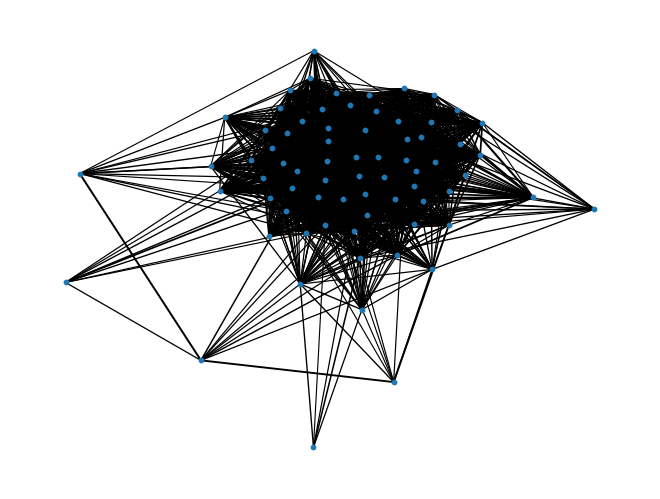

In [12]:
_g = g.subgraph([190,] + list(g.neighbors(190)))
nx.draw(_g, with_labels=False, node_size=10, width=[weight*2 for (u, v, weight) in g.edges(data='weight')])
plt.show()